## 1. Importamos librerías

In [1]:
import os
import numpy as np
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime

# Librerias para constuir la arquitectura U-Net
from tensorflow.keras.layers import Input, Lambda, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

## 2.Preprocesado

In [32]:



def calculate_white_percentage(image):
    """Calcula el porcentaje de píxeles blancos en una imagen."""
    total_pixels = image.shape[0] * image.shape[1]
    white_pixels = np.sum(image == 255)  # Contar píxeles blancos
    return white_pixels / total_pixels


def filter_images_by_white_percentage(data_path_images, data_path_masks, height_shape, width_shape, white_threshold):
    """Filtrar imágenes y seleccionar máscaras basadas en el porcentaje de píxeles blancos."""
    data_list_images = os.listdir(data_path_images)
    filtered_images = []
    filtered_masks = []

    for file_name in tqdm(data_list_images):
        # Leer la imagen
        img = imread(os.path.join(data_path_images, file_name))[:,:,:3]  
        # Calcular el porcentaje de píxeles blancos
        white_percentage = calculate_white_percentage(img)
        
        if white_percentage <= white_threshold:
            # Redimensionar la imagen
            img = resize(img, (height_shape, width_shape), mode='constant', preserve_range=True)
            filtered_images.append(img)

            # Obtener el nombre de la máscara correspondiente
            mask_file = os.path.splitext(file_name)[0] + '.png'  # Nombre de la máscara
            mask_path = os.path.join(data_path_masks, mask_file)
            if os.path.exists(mask_path):
                # Leer y redimensionar la máscara
                maskt = imread(mask_path)[:,:,1]
                maskt = resize(maskt, (height_shape, width_shape), mode='constant', preserve_range=True)
                filtered_masks.append(maskt)

    # Convertir las listas en arrays NumPy
    filtered_images = np.asarray(filtered_images, dtype=np.uint8)
    filtered_masks = np.asarray(filtered_masks, dtype=bool)

    return filtered_images, filtered_masks


# Definir las dimensiones de las imágenes
height_shape = 224
width_shape = 224
white_threshold = 0.25  # Umbral para el porcentaje de píxeles blancos

# Directorios de los conjuntos de datos
data_path_train = "png/train"
data_path_train_mask = "png/train_labels"
data_path_test = "png/test"
data_path_test_mask = "png/test_labels"
data_path_val = "png/val"
data_path_val_mask = "png/val_labels"

# Filtrar imágenes y máscaras para cada conjunto de datos
X_train, Y_train = filter_images_by_white_percentage(data_path_train, data_path_train_mask, height_shape, width_shape, white_threshold)
print('X_train:', X_train.shape)
print('Y_train:', Y_train.shape)

X_test, Y_test = filter_images_by_white_percentage(data_path_test, data_path_test_mask, height_shape, width_shape, white_threshold)
print('X_test:', X_test.shape)
print('Y_test:', Y_test.shape)

X_val, Y_val = filter_images_by_white_percentage(data_path_val, data_path_val_mask, height_shape, width_shape, white_threshold)
print('X_val:', X_val.shape)
print('Y_val:', Y_val.shape)


  0%|          | 0/137 [00:00<?, ?it/s]

100%|██████████| 137/137 [00:40<00:00,  3.35it/s]


X_train: (110, 224, 224, 3)
Y_train: (110, 224, 224)


100%|██████████| 10/10 [00:03<00:00,  2.65it/s]


X_test: (10, 224, 224, 3)
Y_test: (10, 224, 224)


100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

X_val: (4, 224, 224, 3)
Y_val: (4, 224, 224)


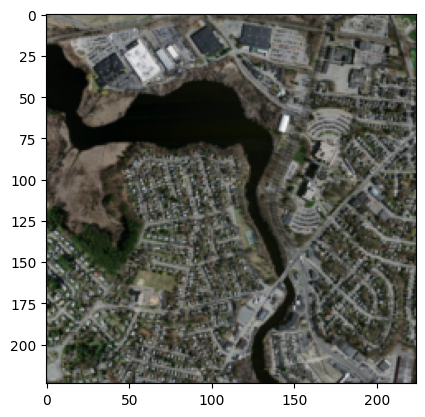

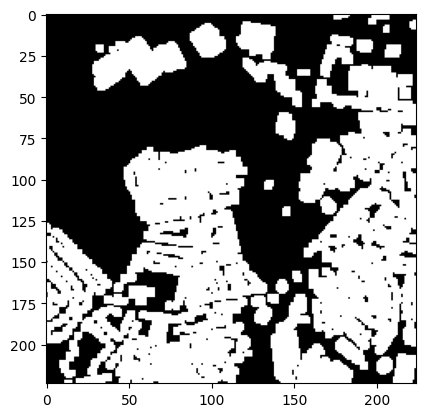

In [33]:
# Mostramos la imagen y su mascara asociada
plt.imshow(X_train[0])
plt.show()
plt.imshow(np.squeeze(Y_train[0]), cmap='gray')
plt.show()

In [9]:
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import tensorflow as tf 
# binary segmentation (this parameters are default when you call Unet('resnet34')
model = sm.Unet('resnet50', classes=1, activation='sigmoid', encoder_weights='imagenet')

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [12]:
import segmentation_models as sm

BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=['accuracy'],
)



In [13]:

model.fit(
   x=X_train,
   y=Y_train,
   batch_size=16,
   epochs=100,
   validation_data=(X_test, Y_test),
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 60s 5s/step - accuracy: 0.6205 - loss: 1.2730 - val_accuracy: 0.3849 - val_loss: 10.3997
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.8413 - loss: 0.8350 - val_accuracy: 0.3849 - val_loss: 10.4856
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - accuracy: 0.8600 - loss: 0.7056 - val_accuracy: 0.3849 - val_loss: 10.4868
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.8537 - loss: 0.6745 - val_accuracy: 0.3849 - val_loss: 10.4583
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.8597 - loss: 0.6321 - val_accuracy: 0.3851 - val_loss: 9.9663
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - accuracy: 0.8624 - loss: 0.6152 - val_accuracy: 0.4508 - val_loss: 6.4094
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - accuracy: 0.8763 - loss: 0.5668 - val_accuracy: 0.5203 - val_loss: 4.9609
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - accuracy: 0.8721 - loss: 0.5736 - val_accuracy: 0.5848 - val_loss: 3.5

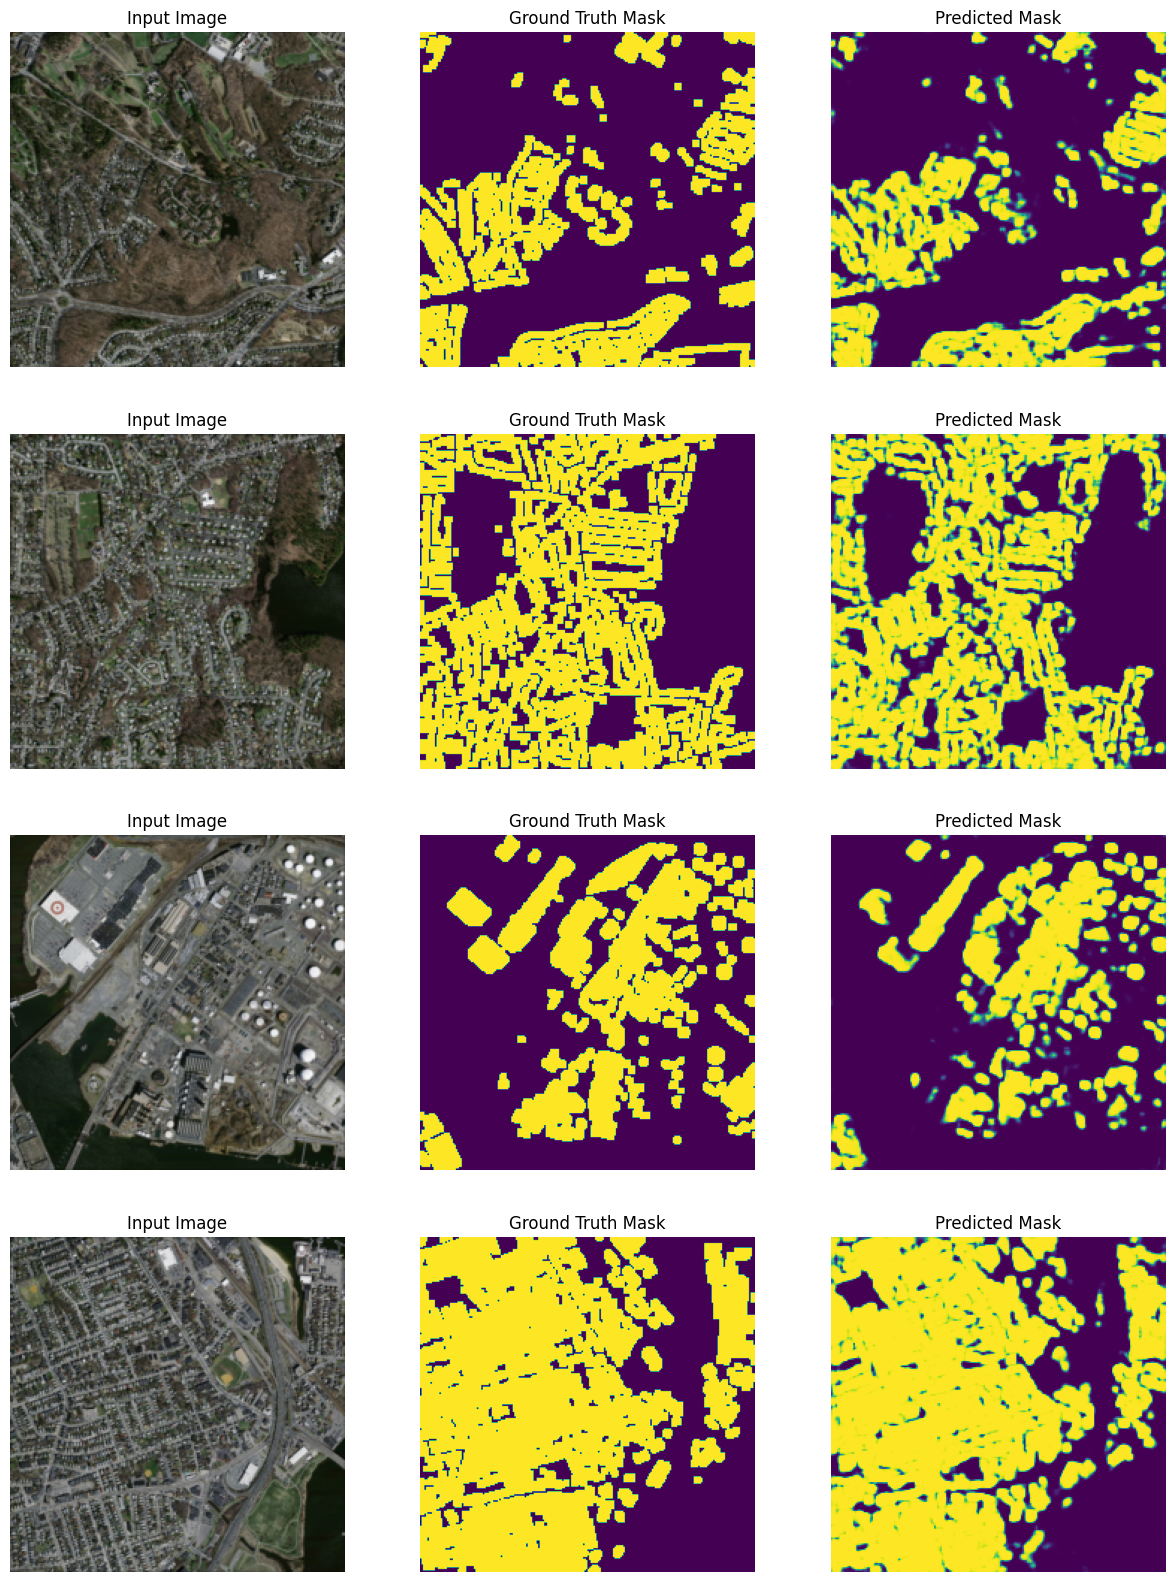

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Función para mostrar un conjunto de imágenes en filas de tres
def display_images_in_rows(images_rows, titles_rows=None):
    num_rows = len(images_rows)
    fig, axs = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))
    
    for i in range(num_rows):
        for j in range(3):
            axs[i, j].imshow(images_rows[i][j])
            axs[i, j].axis('off')
            if titles_rows and i < len(titles_rows) and j < len(titles_rows[i]):
                axs[i, j].set_title(titles_rows[i][j])
    
    plt.show()

# Índices de las imágenes que deseas mostrar agrupadas
indices = [0, 1, 2, 3]

# Preparar imágenes y títulos para visualizar en grupos de tres
images_rows = []
titles_rows = []

# Agrupar imágenes y títulos en filas de tres
for i in range(0, len(indices), 1):
    images_row = []
    titles_row = []
    for j in range(3):
        idx = indices[i]
        input_image = X_val[idx]
        ground_truth_mask = np.squeeze(Y_val[idx])
        predicted_mask = np.squeeze(preds[idx])
        images_row.extend([input_image, ground_truth_mask, predicted_mask])
        titles_row.extend(["Input Image", "Ground Truth Mask", "Predicted Mask"])
    images_rows.append(images_row)
    titles_rows.append(titles_row)

# Mostrar las imágenes en filas de tres
display_images_in_rows(images_rows, titles_rows)


In [ ]:

%env SM_FRAMEWORK=tf.keras
from tensorflow.keras.models import load_model
import tensorflow as tf
import segmentation_models as sm

# Cargar el modelo desde el archivo HDF5 con custom_objects
model_path = '../model_sinblanco.keras'
loaded_model= load_model(model_path, compile=False)


In [ ]:
model.save_weights('../model_sinblanco.weights.h5')  



In [29]:
import segmentation_models as sm

# Establecer el framework de segmentation_models en tf.keras
%env SM_FRAMEWORK=tf.keras

# Definir el backbone y la arquitectura del modelo sin encoder_weights
BACKBONE = 'resnet50'
model = sm.Unet(BACKBONE, classes=1, activation='sigmoid')


env: SM_FRAMEWORK=tf.keras


In [30]:
# Cargar los pesos guardados en el modelo
model.load_weights('../model_sinblanco.weights.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


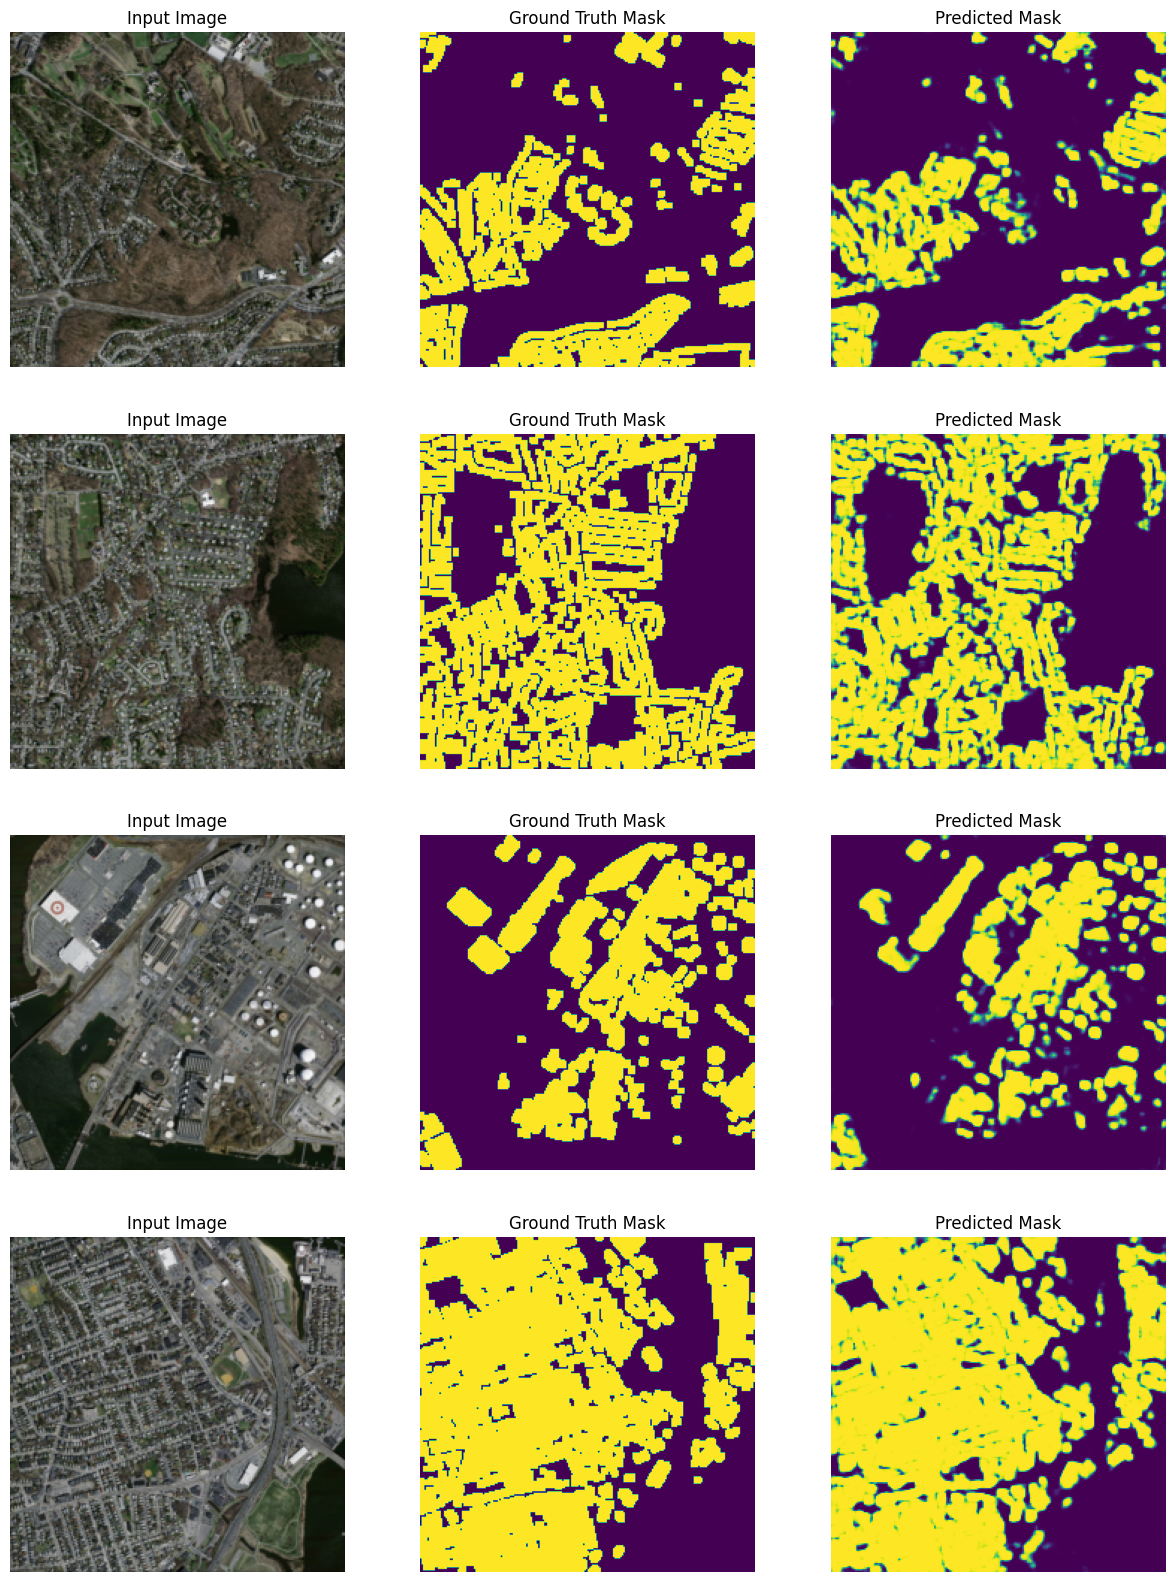

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Función para mostrar un conjunto de imágenes en filas de tres
def display_images_in_rows(images_rows, titles_rows=None):
    num_rows = len(images_rows)
    fig, axs = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))
    
    for i in range(num_rows):
        for j in range(3):
            axs[i, j].imshow(images_rows[i][j])
            axs[i, j].axis('off')
            if titles_rows and i < len(titles_rows) and j < len(titles_rows[i]):
                axs[i, j].set_title(titles_rows[i][j])
    
    plt.show()

# Índices de las imágenes que deseas mostrar agrupadas
indices = [0, 1, 2, 3]

# Preparar imágenes y títulos para visualizar en grupos de tres
images_rows = []
titles_rows = []

preds=model.predict(X_val)

# Agrupar imágenes y títulos en filas de tres
for i in range(0, len(indices), 1):
    images_row = []
    titles_row = []
    for j in range(3):
        idx = indices[i]
        input_image = X_val[idx]
        ground_truth_mask = np.squeeze(Y_val[idx])
        predicted_mask = np.squeeze(preds[idx])
        images_row.extend([input_image, ground_truth_mask, predicted_mask])
        titles_row.extend(["Input Image", "Ground Truth Mask", "Predicted Mask"])
    images_rows.append(images_row)
    titles_rows.append(titles_row)

# Mostrar las imágenes en filas de tres
display_images_in_rows(images_rows, titles_rows)
